In [58]:

# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [59]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
data_df = train_df.append(test_df)

#data_df = pd.read_csv("data/train.csv")

data_df.info()

data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)



d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [60]:
data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [61]:
data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]

In [62]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [63]:
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]


Number of passenger with family/group survival information: 546


In [64]:
data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)

In [65]:
data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)

In [66]:
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)

In [67]:
X = train_df.drop('Survived', 1)
y = train_df['Survived']
X_test = test_df.copy()

In [68]:
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)

In [69]:
n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc")
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
0.879492358564122
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   34.8s finished


In [70]:
train,test=train_test_split(train_df,test_size=0.3,random_state=0,stratify=train_df['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

In [71]:



from keras import models
from keras import layers
from keras import optimizers

model_dnn = models.Sequential()
model_dnn.add(layers.Dense(10, activation='relu', input_shape=(6,)))
model_dnn.add(layers.Dense(10, activation='relu'))
model_dnn.add(layers.Dense(1, activation='sigmoid'))

model_dnn.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])


history = model_dnn.fit(train_X,train_Y,
                   epochs=2000,
                   batch_size=1024,
                   validation_data=(test_X, test_Y))

Train on 623 samples, validate on 268 samples
Epoch 1/2000
623/623 [==============================] - 0s 462us/step - loss: 0.7896 - acc: 0.4141 - val_loss: 0.7604 - val_acc: 0.5112
Epoch 2/2000
623/623 [==============================] - 0s 10us/step - loss: 0.7774 - acc: 0.5056 - val_loss: 0.7529 - val_acc: 0.5112
Epoch 3/2000
623/623 [==============================] - 0s 5us/step - loss: 0.7693 - acc: 0.5056 - val_loss: 0.7470 - val_acc: 0.5336
Epoch 4/2000
623/623 [==============================] - 0s 8us/step - loss: 0.7631 - acc: 0.5265 - val_loss: 0.7421 - val_acc: 0.5336
Epoch 5/2000
623/623 [==============================] - 0s 16us/step - loss: 0.7577 - acc: 0.5265 - val_loss: 0.7376 - val_acc: 0.5410
Epoch 6/2000
623/623 [==============================] - 0s 14us/step - loss: 0.7529 - acc: 0.5490 - val_loss: 0.7337 - val_acc: 0.5410
Epoch 7/2000
623/623 [==============================] - 0s 6us/step - loss: 0.7486 - acc: 0.5457 - val_loss: 0.7299 - val_acc: 0.5634
Epoch 8/200

Epoch 62/2000
623/623 [==============================] - 0s 6us/step - loss: 0.6359 - acc: 0.6212 - val_loss: 0.6294 - val_acc: 0.6157
Epoch 63/2000
623/623 [==============================] - 0s 6us/step - loss: 0.6346 - acc: 0.6212 - val_loss: 0.6282 - val_acc: 0.6157
Epoch 64/2000
623/623 [==============================] - 0s 10us/step - loss: 0.6333 - acc: 0.6212 - val_loss: 0.6271 - val_acc: 0.6194
Epoch 65/2000
623/623 [==============================] - 0s 10us/step - loss: 0.6320 - acc: 0.6260 - val_loss: 0.6259 - val_acc: 0.6194
Epoch 66/2000
623/623 [==============================] - 0s 6us/step - loss: 0.6307 - acc: 0.6260 - val_loss: 0.6248 - val_acc: 0.6157
Epoch 67/2000
623/623 [==============================] - 0s 5us/step - loss: 0.6294 - acc: 0.6324 - val_loss: 0.6236 - val_acc: 0.6157
Epoch 68/2000
623/623 [==============================] - 0s 5us/step - loss: 0.6282 - acc: 0.6324 - val_loss: 0.6224 - val_acc: 0.6157
Epoch 69/2000
623/623 [==============================

Epoch 123/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5663 - acc: 0.7079 - val_loss: 0.5684 - val_acc: 0.7015
Epoch 124/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5653 - acc: 0.7079 - val_loss: 0.5675 - val_acc: 0.7015
Epoch 125/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5642 - acc: 0.7079 - val_loss: 0.5667 - val_acc: 0.7015
Epoch 126/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5632 - acc: 0.7127 - val_loss: 0.5658 - val_acc: 0.7052
Epoch 127/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5622 - acc: 0.7143 - val_loss: 0.5650 - val_acc: 0.7052
Epoch 128/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5611 - acc: 0.7175 - val_loss: 0.5641 - val_acc: 0.7090
Epoch 129/2000
623/623 [==============================] - 0s 8us/step - loss: 0.5601 - acc: 0.7191 - val_loss: 0.5633 - val_acc: 0.7090
Epoch 130/2000
623/623 [========================

Epoch 184/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5067 - acc: 0.7721 - val_loss: 0.5176 - val_acc: 0.7761
Epoch 185/2000
623/623 [==============================] - 0s 8us/step - loss: 0.5059 - acc: 0.7769 - val_loss: 0.5169 - val_acc: 0.7761
Epoch 186/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5051 - acc: 0.7769 - val_loss: 0.5161 - val_acc: 0.7836
Epoch 187/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5044 - acc: 0.7753 - val_loss: 0.5154 - val_acc: 0.7799
Epoch 188/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5036 - acc: 0.7737 - val_loss: 0.5146 - val_acc: 0.7910
Epoch 189/2000
623/623 [==============================] - 0s 5us/step - loss: 0.5028 - acc: 0.7769 - val_loss: 0.5139 - val_acc: 0.7910
Epoch 190/2000
623/623 [==============================] - 0s 6us/step - loss: 0.5021 - acc: 0.7785 - val_loss: 0.5132 - val_acc: 0.7910
Epoch 191/2000
623/623 [========================

Epoch 245/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4583 - acc: 0.7913 - val_loss: 0.4650 - val_acc: 0.8022
Epoch 246/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4576 - acc: 0.7913 - val_loss: 0.4643 - val_acc: 0.8022
Epoch 247/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4568 - acc: 0.7913 - val_loss: 0.4634 - val_acc: 0.8022
Epoch 248/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4561 - acc: 0.7913 - val_loss: 0.4627 - val_acc: 0.8022
Epoch 249/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4553 - acc: 0.7897 - val_loss: 0.4617 - val_acc: 0.8022
Epoch 250/2000
623/623 [==============================] - 0s 3us/step - loss: 0.4545 - acc: 0.7913 - val_loss: 0.4610 - val_acc: 0.8022
Epoch 251/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4536 - acc: 0.7897 - val_loss: 0.4601 - val_acc: 0.8022
Epoch 252/2000
623/623 [========================

Epoch 306/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4129 - acc: 0.8170 - val_loss: 0.4220 - val_acc: 0.8470
Epoch 307/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4122 - acc: 0.8186 - val_loss: 0.4210 - val_acc: 0.8470
Epoch 308/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4116 - acc: 0.8202 - val_loss: 0.4209 - val_acc: 0.8358
Epoch 309/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4109 - acc: 0.8154 - val_loss: 0.4201 - val_acc: 0.8470
Epoch 310/2000
623/623 [==============================] - 0s 5us/step - loss: 0.4102 - acc: 0.8202 - val_loss: 0.4199 - val_acc: 0.8358
Epoch 311/2000
623/623 [==============================] - 0s 6us/step - loss: 0.4096 - acc: 0.8138 - val_loss: 0.4192 - val_acc: 0.8470
Epoch 312/2000
623/623 [==============================] - 0s 8us/step - loss: 0.4089 - acc: 0.8202 - val_loss: 0.4188 - val_acc: 0.8358
Epoch 313/2000
623/623 [========================

Epoch 367/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3882 - acc: 0.8315 - val_loss: 0.4012 - val_acc: 0.8396
Epoch 368/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3880 - acc: 0.8234 - val_loss: 0.4015 - val_acc: 0.8433
Epoch 369/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3878 - acc: 0.8315 - val_loss: 0.4009 - val_acc: 0.8433
Epoch 370/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3876 - acc: 0.8283 - val_loss: 0.4013 - val_acc: 0.8433
Epoch 371/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3874 - acc: 0.8315 - val_loss: 0.4007 - val_acc: 0.8433
Epoch 372/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3872 - acc: 0.8283 - val_loss: 0.4009 - val_acc: 0.8433
Epoch 373/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3870 - acc: 0.8315 - val_loss: 0.4004 - val_acc: 0.8433
Epoch 374/2000
623/623 [=======================

Epoch 428/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3792 - acc: 0.8379 - val_loss: 0.3963 - val_acc: 0.8507
Epoch 429/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3790 - acc: 0.8331 - val_loss: 0.3959 - val_acc: 0.8507
Epoch 430/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3789 - acc: 0.8379 - val_loss: 0.3966 - val_acc: 0.8470
Epoch 431/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3788 - acc: 0.8363 - val_loss: 0.3961 - val_acc: 0.8507
Epoch 432/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3787 - acc: 0.8379 - val_loss: 0.3966 - val_acc: 0.8470
Epoch 433/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3785 - acc: 0.8363 - val_loss: 0.3962 - val_acc: 0.8507
Epoch 434/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3783 - acc: 0.8379 - val_loss: 0.3967 - val_acc: 0.8470
Epoch 435/2000
623/623 [========================

Epoch 489/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3724 - acc: 0.8475 - val_loss: 0.3934 - val_acc: 0.8507
Epoch 490/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3724 - acc: 0.8459 - val_loss: 0.3939 - val_acc: 0.8470
Epoch 491/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3722 - acc: 0.8475 - val_loss: 0.3933 - val_acc: 0.8470
Epoch 492/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3721 - acc: 0.8491 - val_loss: 0.3937 - val_acc: 0.8470
Epoch 493/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3721 - acc: 0.8475 - val_loss: 0.3931 - val_acc: 0.8470
Epoch 494/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3720 - acc: 0.8491 - val_loss: 0.3937 - val_acc: 0.8470
Epoch 495/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3718 - acc: 0.8475 - val_loss: 0.3932 - val_acc: 0.8470
Epoch 496/2000
623/623 [========================

Epoch 550/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3668 - acc: 0.8475 - val_loss: 0.3917 - val_acc: 0.8433
Epoch 551/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3667 - acc: 0.8475 - val_loss: 0.3910 - val_acc: 0.8433
Epoch 552/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3666 - acc: 0.8475 - val_loss: 0.3915 - val_acc: 0.8433
Epoch 553/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3665 - acc: 0.8475 - val_loss: 0.3907 - val_acc: 0.8433
Epoch 554/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3665 - acc: 0.8475 - val_loss: 0.3913 - val_acc: 0.8433
Epoch 555/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3663 - acc: 0.8475 - val_loss: 0.3907 - val_acc: 0.8433
Epoch 556/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3662 - acc: 0.8475 - val_loss: 0.3911 - val_acc: 0.8433
Epoch 557/2000
623/623 [========================

Epoch 611/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3613 - acc: 0.8491 - val_loss: 0.3866 - val_acc: 0.8358
Epoch 612/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3613 - acc: 0.8491 - val_loss: 0.3874 - val_acc: 0.8396
Epoch 613/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3612 - acc: 0.8491 - val_loss: 0.3865 - val_acc: 0.8358
Epoch 614/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3612 - acc: 0.8491 - val_loss: 0.3873 - val_acc: 0.8396
Epoch 615/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3611 - acc: 0.8491 - val_loss: 0.3864 - val_acc: 0.8358
Epoch 616/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3610 - acc: 0.8491 - val_loss: 0.3872 - val_acc: 0.8396
Epoch 617/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3609 - acc: 0.8491 - val_loss: 0.3864 - val_acc: 0.8358
Epoch 618/2000
623/623 [========================

Epoch 672/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3569 - acc: 0.8555 - val_loss: 0.3853 - val_acc: 0.8396
Epoch 673/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3568 - acc: 0.8491 - val_loss: 0.3847 - val_acc: 0.8321
Epoch 674/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3567 - acc: 0.8523 - val_loss: 0.3852 - val_acc: 0.8396
Epoch 675/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3566 - acc: 0.8491 - val_loss: 0.3845 - val_acc: 0.8321
Epoch 676/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3567 - acc: 0.8555 - val_loss: 0.3853 - val_acc: 0.8396
Epoch 677/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3566 - acc: 0.8491 - val_loss: 0.3846 - val_acc: 0.8321
Epoch 678/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3565 - acc: 0.8555 - val_loss: 0.3852 - val_acc: 0.8396
Epoch 679/2000
623/623 [========================

Epoch 733/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3528 - acc: 0.8571 - val_loss: 0.3843 - val_acc: 0.8321
Epoch 734/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3527 - acc: 0.8555 - val_loss: 0.3848 - val_acc: 0.8396
Epoch 735/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3527 - acc: 0.8571 - val_loss: 0.3843 - val_acc: 0.8321
Epoch 736/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3527 - acc: 0.8539 - val_loss: 0.3850 - val_acc: 0.8396
Epoch 737/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3526 - acc: 0.8571 - val_loss: 0.3843 - val_acc: 0.8321
Epoch 738/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3526 - acc: 0.8539 - val_loss: 0.3850 - val_acc: 0.8396
Epoch 739/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3525 - acc: 0.8571 - val_loss: 0.3842 - val_acc: 0.8321
Epoch 740/2000
623/623 [========================

Epoch 794/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3492 - acc: 0.8571 - val_loss: 0.3852 - val_acc: 0.8358
Epoch 795/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3491 - acc: 0.8571 - val_loss: 0.3844 - val_acc: 0.8321
Epoch 796/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3491 - acc: 0.8571 - val_loss: 0.3853 - val_acc: 0.8358
Epoch 797/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3490 - acc: 0.8571 - val_loss: 0.3845 - val_acc: 0.8358
Epoch 798/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3489 - acc: 0.8571 - val_loss: 0.3852 - val_acc: 0.8358
Epoch 799/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3488 - acc: 0.8571 - val_loss: 0.3845 - val_acc: 0.8358
Epoch 800/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3489 - acc: 0.8571 - val_loss: 0.3853 - val_acc: 0.8358
Epoch 801/2000
623/623 [=======================

623/623 [==============================] - 0s 5us/step - loss: 0.3459 - acc: 0.8555 - val_loss: 0.3865 - val_acc: 0.8396
Epoch 855/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3458 - acc: 0.8571 - val_loss: 0.3855 - val_acc: 0.8358
Epoch 856/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3458 - acc: 0.8555 - val_loss: 0.3864 - val_acc: 0.8396
Epoch 857/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3457 - acc: 0.8571 - val_loss: 0.3855 - val_acc: 0.8358
Epoch 858/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3457 - acc: 0.8555 - val_loss: 0.3865 - val_acc: 0.8396
Epoch 859/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3456 - acc: 0.8571 - val_loss: 0.3857 - val_acc: 0.8358
Epoch 860/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3455 - acc: 0.8555 - val_loss: 0.3865 - val_acc: 0.8396
Epoch 861/2000
623/623 [==============================] - 0s 5u

Epoch 915/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3430 - acc: 0.8571 - val_loss: 0.3869 - val_acc: 0.8396
Epoch 916/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3429 - acc: 0.8571 - val_loss: 0.3877 - val_acc: 0.8396
Epoch 917/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3429 - acc: 0.8571 - val_loss: 0.3868 - val_acc: 0.8396
Epoch 918/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3430 - acc: 0.8571 - val_loss: 0.3880 - val_acc: 0.8396
Epoch 919/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3429 - acc: 0.8571 - val_loss: 0.3868 - val_acc: 0.8396
Epoch 920/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3429 - acc: 0.8571 - val_loss: 0.3881 - val_acc: 0.8396
Epoch 921/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3429 - acc: 0.8571 - val_loss: 0.3869 - val_acc: 0.8396
Epoch 922/2000
623/623 [========================

Epoch 976/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3404 - acc: 0.8571 - val_loss: 0.3894 - val_acc: 0.8396
Epoch 977/2000
623/623 [==============================] - 0s 13us/step - loss: 0.3404 - acc: 0.8571 - val_loss: 0.3883 - val_acc: 0.8396
Epoch 978/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3403 - acc: 0.8571 - val_loss: 0.3894 - val_acc: 0.8396
Epoch 979/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3403 - acc: 0.8571 - val_loss: 0.3883 - val_acc: 0.8396
Epoch 980/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3402 - acc: 0.8571 - val_loss: 0.3893 - val_acc: 0.8396
Epoch 981/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3401 - acc: 0.8571 - val_loss: 0.3884 - val_acc: 0.8396
Epoch 982/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3401 - acc: 0.8571 - val_loss: 0.3894 - val_acc: 0.8396
Epoch 983/2000
623/623 [=======================

Epoch 1036/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3380 - acc: 0.8571 - val_loss: 0.3910 - val_acc: 0.8396
Epoch 1037/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3379 - acc: 0.8571 - val_loss: 0.3900 - val_acc: 0.8396
Epoch 1038/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3378 - acc: 0.8571 - val_loss: 0.3909 - val_acc: 0.8396
Epoch 1039/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3377 - acc: 0.8571 - val_loss: 0.3901 - val_acc: 0.8396
Epoch 1040/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3378 - acc: 0.8571 - val_loss: 0.3910 - val_acc: 0.8396
Epoch 1041/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3377 - acc: 0.8571 - val_loss: 0.3902 - val_acc: 0.8396
Epoch 1042/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3377 - acc: 0.8571 - val_loss: 0.3912 - val_acc: 0.8396
Epoch 1043/2000
623/623 [================

Epoch 1096/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3356 - acc: 0.8555 - val_loss: 0.3934 - val_acc: 0.8396
Epoch 1097/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3356 - acc: 0.8571 - val_loss: 0.3921 - val_acc: 0.8396
Epoch 1098/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3356 - acc: 0.8555 - val_loss: 0.3934 - val_acc: 0.8396
Epoch 1099/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3355 - acc: 0.8571 - val_loss: 0.3923 - val_acc: 0.8396
Epoch 1100/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3355 - acc: 0.8555 - val_loss: 0.3934 - val_acc: 0.8396
Epoch 1101/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3354 - acc: 0.8571 - val_loss: 0.3924 - val_acc: 0.8396
Epoch 1102/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3353 - acc: 0.8571 - val_loss: 0.3936 - val_acc: 0.8396
Epoch 1103/2000
623/623 [================

Epoch 1156/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3335 - acc: 0.8555 - val_loss: 0.3958 - val_acc: 0.8396
Epoch 1157/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3335 - acc: 0.8571 - val_loss: 0.3948 - val_acc: 0.8396
Epoch 1158/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3335 - acc: 0.8555 - val_loss: 0.3961 - val_acc: 0.8396
Epoch 1159/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3335 - acc: 0.8571 - val_loss: 0.3949 - val_acc: 0.8507
Epoch 1160/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3336 - acc: 0.8587 - val_loss: 0.3963 - val_acc: 0.8396
Epoch 1161/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3335 - acc: 0.8571 - val_loss: 0.3950 - val_acc: 0.8396
Epoch 1162/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3334 - acc: 0.8555 - val_loss: 0.3962 - val_acc: 0.8396
Epoch 1163/2000
623/623 [===============

Epoch 1216/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3317 - acc: 0.8604 - val_loss: 0.3981 - val_acc: 0.8396
Epoch 1217/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3317 - acc: 0.8587 - val_loss: 0.3969 - val_acc: 0.8507
Epoch 1218/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3317 - acc: 0.8604 - val_loss: 0.3981 - val_acc: 0.8396
Epoch 1219/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3316 - acc: 0.8587 - val_loss: 0.3971 - val_acc: 0.8507
Epoch 1220/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3315 - acc: 0.8604 - val_loss: 0.3981 - val_acc: 0.8396
Epoch 1221/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3315 - acc: 0.8571 - val_loss: 0.3971 - val_acc: 0.8507
Epoch 1222/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3315 - acc: 0.8604 - val_loss: 0.3984 - val_acc: 0.8396
Epoch 1223/2000
623/623 [================

Epoch 1276/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3301 - acc: 0.8604 - val_loss: 0.4002 - val_acc: 0.8396
Epoch 1277/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3300 - acc: 0.8571 - val_loss: 0.3989 - val_acc: 0.8470
Epoch 1278/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3300 - acc: 0.8604 - val_loss: 0.4002 - val_acc: 0.8396
Epoch 1279/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3299 - acc: 0.8571 - val_loss: 0.3991 - val_acc: 0.8470
Epoch 1280/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3299 - acc: 0.8604 - val_loss: 0.4003 - val_acc: 0.8396
Epoch 1281/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3299 - acc: 0.8571 - val_loss: 0.3990 - val_acc: 0.8470
Epoch 1282/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3299 - acc: 0.8604 - val_loss: 0.4003 - val_acc: 0.8396
Epoch 1283/2000
623/623 [================

Epoch 1336/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3284 - acc: 0.8604 - val_loss: 0.4019 - val_acc: 0.8396
Epoch 1337/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3283 - acc: 0.8571 - val_loss: 0.4008 - val_acc: 0.8507
Epoch 1338/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3284 - acc: 0.8604 - val_loss: 0.4017 - val_acc: 0.8396
Epoch 1339/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3282 - acc: 0.8571 - val_loss: 0.4010 - val_acc: 0.8470
Epoch 1340/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3282 - acc: 0.8604 - val_loss: 0.4019 - val_acc: 0.8358
Epoch 1341/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3282 - acc: 0.8571 - val_loss: 0.4009 - val_acc: 0.8507
Epoch 1342/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3283 - acc: 0.8604 - val_loss: 0.4021 - val_acc: 0.8396
Epoch 1343/2000
623/623 [===============

Epoch 1396/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3271 - acc: 0.8604 - val_loss: 0.4037 - val_acc: 0.8396
Epoch 1397/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3270 - acc: 0.8571 - val_loss: 0.4024 - val_acc: 0.8507
Epoch 1398/2000
623/623 [==============================] - 0s 11us/step - loss: 0.3268 - acc: 0.8604 - val_loss: 0.4033 - val_acc: 0.8396
Epoch 1399/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3267 - acc: 0.8571 - val_loss: 0.4025 - val_acc: 0.8507
Epoch 1400/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3266 - acc: 0.8604 - val_loss: 0.4034 - val_acc: 0.8396
Epoch 1401/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3267 - acc: 0.8571 - val_loss: 0.4025 - val_acc: 0.8507
Epoch 1402/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3266 - acc: 0.8604 - val_loss: 0.4035 - val_acc: 0.8396
Epoch 1403/2000
623/623 [===============

Epoch 1456/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3254 - acc: 0.8604 - val_loss: 0.4060 - val_acc: 0.8396
Epoch 1457/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3254 - acc: 0.8571 - val_loss: 0.4047 - val_acc: 0.8545
Epoch 1458/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3254 - acc: 0.8604 - val_loss: 0.4060 - val_acc: 0.8396
Epoch 1459/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3253 - acc: 0.8571 - val_loss: 0.4048 - val_acc: 0.8545
Epoch 1460/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3253 - acc: 0.8604 - val_loss: 0.4062 - val_acc: 0.8507
Epoch 1461/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3253 - acc: 0.8604 - val_loss: 0.4048 - val_acc: 0.8545
Epoch 1462/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3253 - acc: 0.8604 - val_loss: 0.4062 - val_acc: 0.8507
Epoch 1463/2000
623/623 [==============

Epoch 1516/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3238 - acc: 0.8604 - val_loss: 0.4085 - val_acc: 0.8507
Epoch 1517/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3238 - acc: 0.8604 - val_loss: 0.4075 - val_acc: 0.8545
Epoch 1518/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3238 - acc: 0.8604 - val_loss: 0.4088 - val_acc: 0.8507
Epoch 1519/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3238 - acc: 0.8604 - val_loss: 0.4074 - val_acc: 0.8545
Epoch 1520/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3239 - acc: 0.8604 - val_loss: 0.4091 - val_acc: 0.8507
Epoch 1521/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3239 - acc: 0.8604 - val_loss: 0.4074 - val_acc: 0.8545
Epoch 1522/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3240 - acc: 0.8604 - val_loss: 0.4091 - val_acc: 0.8507
Epoch 1523/2000
623/623 [================

Epoch 1576/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3227 - acc: 0.8604 - val_loss: 0.4109 - val_acc: 0.8507
Epoch 1577/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3227 - acc: 0.8604 - val_loss: 0.4096 - val_acc: 0.8545
Epoch 1578/2000
623/623 [==============================] - 0s 11us/step - loss: 0.3226 - acc: 0.8604 - val_loss: 0.4109 - val_acc: 0.8507
Epoch 1579/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3226 - acc: 0.8604 - val_loss: 0.4097 - val_acc: 0.8545
Epoch 1580/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3226 - acc: 0.8604 - val_loss: 0.4111 - val_acc: 0.8507
Epoch 1581/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3226 - acc: 0.8604 - val_loss: 0.4097 - val_acc: 0.8545
Epoch 1582/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3226 - acc: 0.8604 - val_loss: 0.4113 - val_acc: 0.8507
Epoch 1583/2000
623/623 [===============

Epoch 1636/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3216 - acc: 0.8604 - val_loss: 0.4130 - val_acc: 0.8507
Epoch 1637/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3216 - acc: 0.8604 - val_loss: 0.4117 - val_acc: 0.8545
Epoch 1638/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3216 - acc: 0.8604 - val_loss: 0.4133 - val_acc: 0.8507
Epoch 1639/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3216 - acc: 0.8604 - val_loss: 0.4117 - val_acc: 0.8545
Epoch 1640/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3216 - acc: 0.8604 - val_loss: 0.4131 - val_acc: 0.8507
Epoch 1641/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3214 - acc: 0.8604 - val_loss: 0.4119 - val_acc: 0.8545
Epoch 1642/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3213 - acc: 0.8604 - val_loss: 0.4130 - val_acc: 0.8507
Epoch 1643/2000
623/623 [===============

Epoch 1696/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3204 - acc: 0.8604 - val_loss: 0.4142 - val_acc: 0.8507
Epoch 1697/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3204 - acc: 0.8604 - val_loss: 0.4129 - val_acc: 0.8545
Epoch 1698/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3205 - acc: 0.8604 - val_loss: 0.4144 - val_acc: 0.8507
Epoch 1699/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3205 - acc: 0.8620 - val_loss: 0.4129 - val_acc: 0.8545
Epoch 1700/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3205 - acc: 0.8604 - val_loss: 0.4144 - val_acc: 0.8507
Epoch 1701/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3205 - acc: 0.8620 - val_loss: 0.4130 - val_acc: 0.8545
Epoch 1702/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3203 - acc: 0.8604 - val_loss: 0.4142 - val_acc: 0.8507
Epoch 1703/2000
623/623 [===============

Epoch 1756/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3195 - acc: 0.8604 - val_loss: 0.4155 - val_acc: 0.8507
Epoch 1757/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3195 - acc: 0.8620 - val_loss: 0.4144 - val_acc: 0.8545
Epoch 1758/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3195 - acc: 0.8604 - val_loss: 0.4155 - val_acc: 0.8507
Epoch 1759/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3194 - acc: 0.8620 - val_loss: 0.4144 - val_acc: 0.8545
Epoch 1760/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3195 - acc: 0.8604 - val_loss: 0.4156 - val_acc: 0.8507
Epoch 1761/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3194 - acc: 0.8620 - val_loss: 0.4145 - val_acc: 0.8545
Epoch 1762/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3196 - acc: 0.8604 - val_loss: 0.4158 - val_acc: 0.8507
Epoch 1763/2000
623/623 [===============

Epoch 1816/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3188 - acc: 0.8604 - val_loss: 0.4171 - val_acc: 0.8507
Epoch 1817/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3188 - acc: 0.8620 - val_loss: 0.4158 - val_acc: 0.8545
Epoch 1818/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3189 - acc: 0.8604 - val_loss: 0.4171 - val_acc: 0.8507
Epoch 1819/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3188 - acc: 0.8620 - val_loss: 0.4159 - val_acc: 0.8545
Epoch 1820/2000
623/623 [==============================] - 0s 3us/step - loss: 0.3187 - acc: 0.8604 - val_loss: 0.4168 - val_acc: 0.8507
Epoch 1821/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3186 - acc: 0.8620 - val_loss: 0.4159 - val_acc: 0.8545
Epoch 1822/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3186 - acc: 0.8604 - val_loss: 0.4167 - val_acc: 0.8507
Epoch 1823/2000
623/623 [================

Epoch 1876/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3181 - acc: 0.8604 - val_loss: 0.4181 - val_acc: 0.8507
Epoch 1877/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3180 - acc: 0.8620 - val_loss: 0.4169 - val_acc: 0.8545
Epoch 1878/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3179 - acc: 0.8604 - val_loss: 0.4178 - val_acc: 0.8545
Epoch 1879/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3178 - acc: 0.8620 - val_loss: 0.4170 - val_acc: 0.8545
Epoch 1880/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3178 - acc: 0.8604 - val_loss: 0.4179 - val_acc: 0.8545
Epoch 1881/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3178 - acc: 0.8620 - val_loss: 0.4170 - val_acc: 0.8545
Epoch 1882/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3178 - acc: 0.8604 - val_loss: 0.4179 - val_acc: 0.8545
Epoch 1883/2000
623/623 [===============

Epoch 1936/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3173 - acc: 0.8604 - val_loss: 0.4190 - val_acc: 0.8545
Epoch 1937/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3172 - acc: 0.8620 - val_loss: 0.4181 - val_acc: 0.8545
Epoch 1938/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3171 - acc: 0.8620 - val_loss: 0.4190 - val_acc: 0.8545
Epoch 1939/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3171 - acc: 0.8620 - val_loss: 0.4181 - val_acc: 0.8545
Epoch 1940/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3172 - acc: 0.8620 - val_loss: 0.4191 - val_acc: 0.8545
Epoch 1941/2000
623/623 [==============================] - 0s 6us/step - loss: 0.3171 - acc: 0.8620 - val_loss: 0.4181 - val_acc: 0.8545
Epoch 1942/2000
623/623 [==============================] - 0s 10us/step - loss: 0.3171 - acc: 0.8620 - val_loss: 0.4191 - val_acc: 0.8545
Epoch 1943/2000
623/623 [==============

Epoch 1996/2000
623/623 [==============================] - 0s 11us/step - loss: 0.3165 - acc: 0.8620 - val_loss: 0.4201 - val_acc: 0.8545
Epoch 1997/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3164 - acc: 0.8620 - val_loss: 0.4191 - val_acc: 0.8545
Epoch 1998/2000
623/623 [==============================] - 0s 5us/step - loss: 0.3164 - acc: 0.8620 - val_loss: 0.4201 - val_acc: 0.8545
Epoch 1999/2000
623/623 [==============================] - 0s 8us/step - loss: 0.3164 - acc: 0.8620 - val_loss: 0.4191 - val_acc: 0.8545
Epoch 2000/2000
623/623 [==============================] - 0s 21us/step - loss: 0.3165 - acc: 0.8620 - val_loss: 0.4203 - val_acc: 0.8545


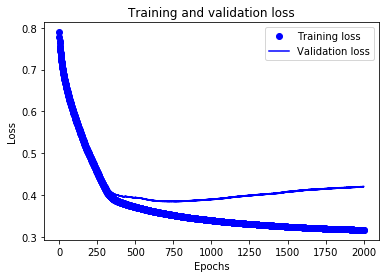

In [72]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']

epochs=range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo' , label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

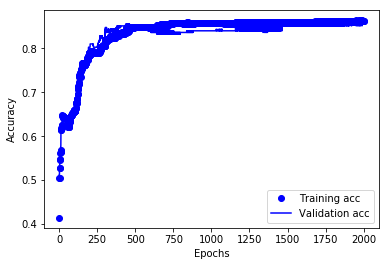

In [73]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo' , label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
#dnn_predict = model_dnn.predict(data_x)
#submission = pd.DataFrame({
#        "PassengerId": data["PassengerId"],
#        "Survived": prediction2
#    })
#submission.to_csv('submission_dnn13.csv', index=False)

In [78]:
test_df = pd.read_csv("data/test.csv")

prediction2=model_dnn.predict(X_test)

y_final = (prediction2 > 0.5).astype(int).ravel()

submission = pd.DataFrame({
         "PassengerId": test_df["PassengerId"],
         "Survived": y_final
     })
submission.to_csv('submission3_1.csv', index=False)